# Classe Self-Attention

Nesta seção, você aprenderá a criar cabeças de autoatenção do zero.



### Setup

In [1]:
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib.util
import subprocess
import sys

def check_and_install(package, pip_name=None):
    if pip_name is None:
        pip_name = package
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} não está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    else:
        print(f"{package} já está instalado.")

In [2]:
# check_and_install('Levenshtein')
# check_and_install('torch','torch==2.3.0')
# check_and_install('torchtext','torchtext==0.18.0')

### Importar bibliotecas

In [3]:
import os
import sys
import time
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

### Funções auxiliares

In [32]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

### Head
A classe `Head` representa uma cabeça de autoatenção. Ela estende o `nn.Module` do PyTorch, tornando-a parte de uma rede neural que pode aprender com dados.
<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/attention.png" width="200" alt="attention"/>
</p>
$$
Attention(Q, K, V)  => Attention(Q \cdot W^Q, K \cdot W^K, V \cdot W^V)
$$

In [4]:
class Head(nn.Module):
    """
    Self attention head.
    This class implements a self-attention mechanism
    which is a key component of transformer-based neural network archtectures
    """

    def __init__(self):
        super().__init__() # Initialize the superclass nn.Module
        # Embeddings layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # Linear layers to compute the queries, keys, and values from the embeddings
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # Query * Keys / normalization
        w = F.softmax(w, dim=-1) # Do a softmax across the last dimension
        return embedded_x, k, q, v, w

    def forward(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        # Add weighted values
        out = w @ v
        return out

### Definição do conjunto de dados
Para ilustrar as transformações no texto de entrada, um conjunto de dados de amostra é definido, que parece ser uma lista de tuplas, cada uma contendo um ID e uma sequência de texto relacionada a várias tarefas de PNL.

In [5]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

### Configuração de tokenização
Um tokenizador é criado usando a função `get_tokenizer` do `torchtext`, que dividirá as strings em tokens (palavras).

In [7]:
# Get a basic English tokenizer
tokenizer = get_tokenizer("basic_english")  

### Construir vocabulário
A função `yield_tokens` itera o conjunto de dados e produz versões tokenizadas dos dados de texto.

In [8]:
def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

In [9]:
vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

### Pipeline de processamento de texto
Uma função `text_pipeline` é definida para converter strings de texto bruto em índices de token usando o tokenizador e o vocabulário.

In [11]:
def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    # Tokenize the input and map each token to its index in the vocabulary
    return vocab(tokenizer(x))  

### Definição de hiperparâmetros
Os hiperparâmetros para o modelo são especificados, incluindo o tamanho do vocabulário e a dimensão de incorporação.

In [12]:
vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

### Dados dummy para teste
Dados de entrada fictícios são criados para teste, e a função `text_pipeline` é aplicada para converter o texto de entrada em um tensor de índices de token, que será usado como entrada para o modelo de rede neural.

In [13]:
# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'

In [14]:
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

In [15]:
# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


In [16]:
# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

In [17]:
# Print the size of the resulting embedded vector for verification

# Should show the shape as [number of tokens, embedding dimension]
print(embedded_x.shape)

# The actual embedded representations of the input tokens
print("embedded_x:", embedded_x)  

torch.Size([5, 3])
embedded_x: tensor([[-0.6312, -0.2395, -1.5213],
        [-0.7608,  1.4178, -0.1622],
        [ 1.7098,  0.4315,  2.5018],
        [-0.1022, -0.6515, -0.5351],
        [-0.0180, -0.9021, -0.1368]], grad_fn=<EmbeddingBackward0>)


In [18]:
# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])


In [19]:
# Now we actually pass the input data through the entire attention head to get the output
output = attention_head(input_data)

In [20]:
# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5, 3])
tensor([[ 0.1044, -0.0738, -0.0991],
        [-0.2892,  0.3519, -0.0246],
        [-0.3222,  0.2815,  0.1849],
        [ 0.1056, -0.1125, -0.0278],
        [ 0.1122, -0.1303, -0.0088]], grad_fn=<MmBackward0>)


### Codificação posicional

Para ilustrar, considere as frases: 'He painted the car red' e 'He painted the red car' Essas frases têm significados diferentes devido às diferentes posições das palavras 'red' e 'car'. Codificações posicionais implementadas corretamente permitiriam que o modelo distinguisse entre as posições dessas palavras, garantindo que os embeddings para essas frases fossem distintos.

Em tarefas de processamento de sequência, é crucial que o modelo entenda as posições dos elementos dentro de uma sequência. Consiga isso associando cada amostra a um índice de posição exclusivo, denotado como $p_{n}=n$, onde $n$ representa a posição da amostra na sequência. Para elaborar, vamos considerar uma sequência de elementos. Comece atribuindo o índice 0 ao primeiro elemento, o índice 1 ao segundo e assim por diante. Essa técnica simples, mas eficaz, permite que o modelo entenda as posições relativas dos elementos na sequência. É importante ressaltar que esse método permanece confiável mesmo ao lidar com sequências longas, estendendo-se até onde nosso vocabulário permite. Ao incorporar codificações posicionais, nosso modelo obtém uma compreensão profunda da ordem e do arranjo dos elementos, aprimorando seu desempenho em várias tarefas relacionadas à sequência.

A posição impressa abaixo incorpora todo o comprimento do tamanho do vocabulário.

In [21]:
# Generate a range of position indices from 0 to the size of the vocabulary
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)

In [22]:
# Retrieve the list of words from the vocabulary object
vocab_list = list(vocab.get_itos())

In [23]:
# Iterate over the range of vocabulary size
for idx in range(vocab_size):
    word = vocab_list[idx]  # Get the word from the vocabulary list at the current index
    pos = position[idx][0].item()  # Extract the numerical value of the position index from the tensor
    print(f"Word: {word}, Position Index: {pos}")

Word: <unk>, Position Index: 0.0
Word: nlp, Position Index: 1.0
Word: pytorch, Position Index: 2.0
Word: analysis, Position Index: 3.0
Word: entity, Position Index: 4.0
Word: machine, Position Index: 5.0
Word: named, Position Index: 6.0
Word: sentiment, Position Index: 7.0
Word: translation, Position Index: 8.0
Word: with, Position Index: 9.0
Word: ,, Position Index: 10.0
Word: car, Position Index: 11.0
Word: he, Position Index: 12.0
Word: painted, Position Index: 13.0
Word: red, Position Index: 14.0
Word: the, Position Index: 15.0
Word: basics, Position Index: 16.0
Word: classification, Position Index: 17.0
Word: for, Position Index: 18.0
Word: introduction, Position Index: 19.0
Word: of, Position Index: 20.0
Word: recognition, Position Index: 21.0
Word: techniques, Position Index: 22.0
Word: text, Position Index: 23.0
Word: to, Position Index: 24.0
Word: using, Position Index: 25.0
Word: vs, Position Index: 26.0


Em codificações posicionais, cada dimensão \(d\) dentro da incorporação tem importância específica, denotada como $\textbf{p}_{n,d}$. Por exemplo, se você tem uma dimensão de incorporação de três, as codificações posicionais $\textbf{p}_{n,d}$ são representadas como $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$. Esses valores correspondem a uma incorporação tridimensional para cada token, capturando sua posição e características únicas dentro da sequência. Ao organizar as informações posicionais dessa forma, o modelo obtém uma compreensão mais rica do relacionamento entre os tokens.

In [24]:
# Initialize a matrix of zeros with dimensions [vocab_size, n_embd]
# This will be used to hold the positional encodings for each word in the vocabulary
pe = torch.zeros(vocab_size, n_embd)

In [25]:
# Concatenate the position tensor three times along dimension 1 (columns)
# This simplistic example is likely a placeholder for a more complex function of position that would be used in a real positional encoding
pe = torch.cat((position, position, position), 1)

In [26]:
# Display the positional encoding tensor
# In an actual implementation, this would involve a more sophisticated method that reflects the position's impact on the embeddings
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

Você só precisa de codificações posicionais para cada sequência de embeddings, para determinar isso. Em seguida, conte o número de embeddings na sequência. Consulte a frase 'he painted the car red he painted the red car' em meus **`my_embdings`**.

In [27]:
# Obtain the shape of the embedded_x tensor which contains the embedded representations
# 'samples' will hold the number of tokens/samples in the batch
# 'dim' will hold the dimensionality of the embeddings
samples, dim = embedded_x.shape

In [28]:
# Print the tuple (samples, dim) to show the size of the batch and the embedding dimension
samples, dim

(5, 3)

In [29]:
# Select the appropriate positional encodings based on the number of samples and embedding dimensions
# This slice of the positional encoding tensor 'pe' corresponds to the actual batch size and embedding size
pe_slice = pe[0:samples, 0:n_embd]

In [30]:
# Add the positional encodings to the token embeddings
# This step integrates the position information into the embeddings
pos_embding = embedded_x + pe_slice

# The result 'pos_embding' now contains the token embeddings adjusted with positional information
# Display the adjusted embeddings tensor
pos_embding

tensor([[-0.6312, -0.2395, -1.5213],
        [ 0.2392,  2.4178,  0.8378],
        [ 3.7098,  2.4315,  4.5018],
        [ 2.8978,  2.3485,  2.4649],
        [ 3.9820,  3.0979,  3.8632]], grad_fn=<AddBackward0>)

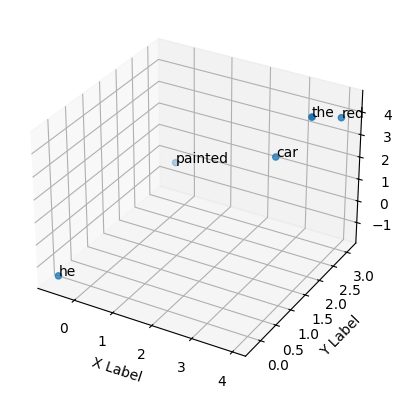

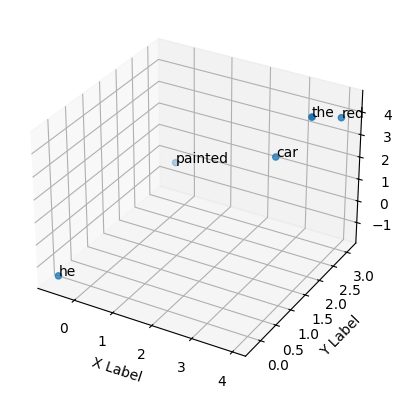

In [33]:
# Visualize the embeddings with positional encodings using the defined plot function
# 'pos_embding.detach().numpy()' converts the embeddings tensor to a NumPy array and detaches it from the current computation graph
# 'tokenizer(my_tokens)' tokenizes the sample sentence for labeling in the plot
# 'vocab' is passed to associate tokens with their embeddings for plotting
plot_embdings(pos_embding.detach().numpy(), tokenizer(my_tokens), vocab)
plot_embdings(pos_embding.detach().numpy(),tokenizer(my_tokens),vocab)

Ao incorporar codificações posicionais lineares em embeddings, surge um desafio significativo: os embeddings para posições posteriores na sequência tendem a se tornar muito maiores. Esse problema se torna especialmente proeminente com sequências mais longas. Para ilustrar, vamos considerar a palavra "car" aparecendo nos índices 3 e 9 dentro de uma sequência. O embedding para "car" na posição 9 é visivelmente maior do que o da posição 3. Essa diferença se torna mais pronunciada à medida que o comprimento da sequência aumenta.

O problema aqui é que os embeddings têm a intenção de representar palavras ou tokens de maneira consistente. Diferenças excessivas em magnitude podem levar a uma divergência dos embeddings originais, tornando desafiador para o modelo interpretar e processar a sequência de forma eficaz. É crucial abordar esse problema para manter a integridade dos embeddings e garantir que as informações posicionais aprimorem, em vez de distorcer, a representação geral das palavras na sequência.

In [34]:
pos_embding[3]# add -3 to get original embedding

tensor([2.8978, 2.3485, 2.4649], grad_fn=<SelectBackward0>)

In [35]:
pos_embding[-1]#add -9 original embedding

tensor([3.9820, 3.0979, 3.8632], grad_fn=<SelectBackward0>)

Aborde essa questão de magnitude por meio de várias abordagens. Primeiro, empregue uma função que não exiba uma amplificação tão significativa. Além disso, tenha a opção de introduzir funções diferentes. Por exemplo, ao considerar nossas codificações posicionais de palavras, a magnitude das codificações posicionais $\textbf{p}_{n,d}$ pode ser representada como $[p_{n,1}, p_{n,2}, p_{n,3}]$, que, neste caso, se traduz em $[0,1n, -0,1n, 0]$.

Neste esquema modificado, as magnitudes das duas primeiras dimensões $[p_{n,1}, p_{n,2}]$ aumentam linearmente com a posição $n$, mas a uma taxa mais lenta (0,1 vezes a posição). A terceira dimensão $[p_{n,3}]$ permanece constante em 0. Ajustar esses coeficientes pode controlar a taxa na qual as magnitudes mudam, garantindo que as incorporações não aumentem significativamente e fornecendo uma representação mais equilibrada das posições dentro da sequência.

In [36]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

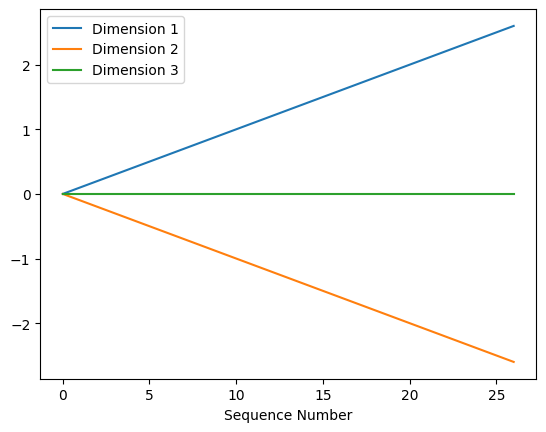

In [37]:
# Plot the first dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 0].numpy(), label="Dimension 1")

# Plot the second dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 1].numpy(), label="Dimension 2")

# Plot the third dimension of positional encodings for all positions in the sequence
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

# Label the x-axis as 'Sequence Number' to represent the position in the sequence
plt.xlabel("Sequence Number")

# Add a legend to the plot to identify which line corresponds to which dimension of positional encoding
plt.legend()

# Display the plot on screen
plt.show()

Observe que as palavras estão mais próximas, mas empregar uma função linear ainda apresenta as mesmas desvantagens. Isso significa que, eventualmente, os embeddings continuarão aumentando linearmente.

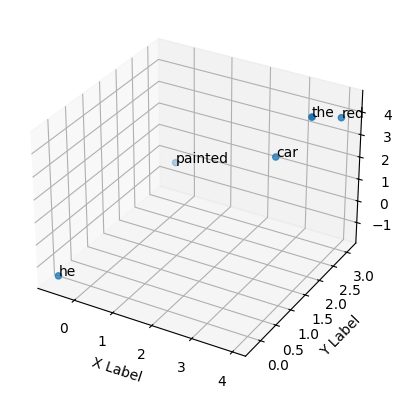

In [38]:
# After the positional encodings have been added, we need to detach the tensor from the computation graph
# and convert it to a NumPy array for visualization
# 'detach()' is necessary because 'embedded_x' requires gradients and we don't need them for plotting
# 'numpy()' converts the PyTorch tensor to a NumPy array
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the sample sentence to use as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the token embeddings with positional encodings
# The 'plot_embdings' function presumably takes the NumPy array of embeddings, token labels, and a vocabulary
# to plot the embeddings in a space where similar embeddings are closer together
plot_embdings(pos_embding_numpy, tokens, vocab)

Ao analisar codificações posicionais, pode parecer que as palavras estão mais próximas, indicando uma melhoria. No entanto, é crucial reconhecer que o uso de uma função linear ainda vem com seu próprio conjunto de limitações. Apesar da impressão visual de palavras estarem mais próximas, codificações posicionais lineares têm problemas inerentes. Um problema significativo é o potencial de amplificar magnitudes conforme as posições progridem, o que pode afetar adversamente a capacidade do modelo de capturar nuances posicionais sutis de forma eficaz.

Para superar esses desafios, explorar métodos e funções alternativas para gerar codificações posicionais é valioso. Uma abordagem promissora envolve alavancar funções periódicas, como funções seno e cosseno. Essas funções possuem uma propriedade única chamada periodicidade, o que significa que elas repetem seus valores em intervalos regulares. Essa natureza periódica impede que elas cresçam muito rapidamente conforme as posições aumentam na sequência.

Ao incorporar funções seno e cosseno em codificações posicionais, introduz um mecanismo mais sensível ao contexto e adaptável. Essas funções nos permitem capturar as informações sequenciais sem o risco de magnitudes escalarem incontrolavelmente. Como resultado, o modelo pode discernir melhor as posições relativas das palavras dentro da sequência, levando a representações mais precisas e significativas.

In [39]:
# Generate positional encodings using a sinusoidal function and concatenation
# The first dimension is encoded with a sine function
# The second and third dimensions are placeholders and are simply set to 1 (this is not typical in practice and likely serves as a simplified example)
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),  # Sinusoidal encoding for dimension 1
                0 * position + 1,                     # Constant encoding (1) for dimension 2
                0 * position + 1), axis=1)            # Constant encoding (1) for dimension 3

In [40]:
# Add the sinusoidal positional encodings to the token embeddings
# This step enriches the embeddings with information about the position of each token in the sequence
pos_embding = embedded_x + pe[0:samples, :]

In [41]:
# Prepare the positional embeddings for visualization
# 'detach()' is used to stop tracking all operations on 'pos_embding'
# 'numpy()' converts the tensor to a NumPy array suitable for plotting
pos_embding_numpy = pos_embding.detach().numpy()

In [42]:
# Tokenize the sample sentence to get the labels for the embedding plot
tokens = tokenizer(my_tokens)

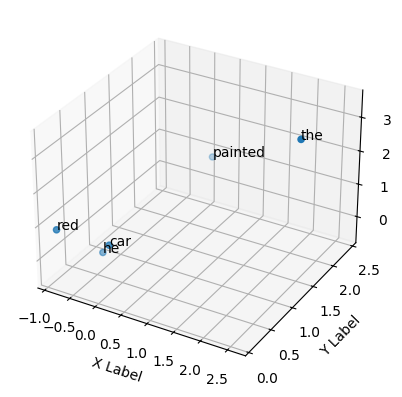

In [43]:
# Visualize the embeddings using the plot function
# It is assumed the function will plot these embeddings in a way that illustrates the effects of adding positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

A primeira dimensão de **$pe$** segue um padrão de onda senoidal, enquanto a 2ª e a 3ª dimensões têm valores constantes. Isso é mostrado no gráfico abaixo.

In [44]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

Em nossa exploração de embeddings de palavras, notamos um padrão fascinante: as palavras são geralmente posicionadas perto o suficiente no espaço de embedding para preservar sua proximidade, garantindo que elas sejam contextualmente relacionadas, mantendo a distinção umas das outras. No entanto, há uma exceção significativa que surge especificamente com a palavra 'car'.

Esse comportamento peculiar pode ser atribuído à natureza da onda senoidal usada na codificação posicional. A onda senoidal é inerentemente periódica, o que significa que ela repete seu padrão em intervalos regulares. Essa periodicidade é visualmente ilustrada na imagem anexa, onde você pode observar a curva senoidal se repetindo. Como resultado, a codificação posicional para a palavra 'car' em diferentes locais dentro da sequência permanece a mesma.

Essa natureza periódica representa um desafio, especialmente para palavras como "car", que podem aparecer várias vezes em uma sequência, mas carregam significados contextuais diferentes a cada vez. Apesar de seus contextos variados, a codificação posicional para todas as ocorrências de "car" seria idêntica devido ao padrão repetitivo da onda senoidal.

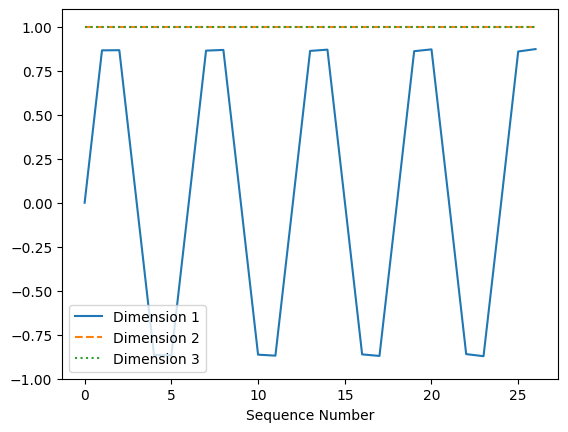

In [45]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

Ao incorporar funções seno e cosseno com frequências variadas, codifique sequências de diferentes comprimentos. Como demonstrado aqui, torna-se evidente que essas codificações posicionam os elementos de tal forma que eles mantêm proximidade enquanto ainda preservam sua distinção uns dos outros

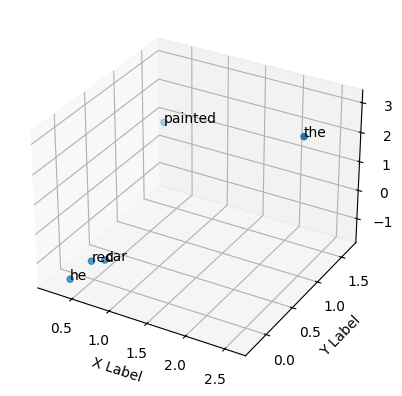

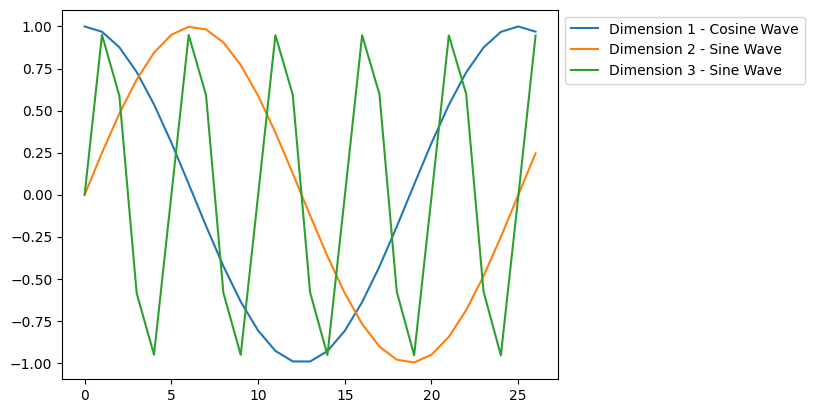

In [46]:
# Create positional encodings using sinusoidal functions
# Concatenate cosine and sine functions for different dimensions to form the encoding
pe = torch.cat((torch.cos(2 * 3.14 * position / 25),  # Cosine function for the first dimension
                torch.sin(2 * 3.14 * position / 25),  # Sine function for the second dimension
                torch.sin(2 * 3.14 * position / 5)), axis=1)  # Sine function with different frequency for the third dimension

# Add the generated positional encodings to the token embeddings
# This enriches the embeddings with positional information
pos_embding = embedded_x + pe[0:samples, :]

# Detach the embeddings from the computational graph and convert to NumPy for visualization
pos_embding_numpy = pos_embding.detach().numpy()

# Tokenize the input text to be used as labels in the plot
tokens = tokenizer(my_tokens)

# Visualize the embeddings with positional encodings
plot_embdings(pos_embding_numpy, tokens, vocab)

# Additionally, plot each dimension of the positional encodings to visualize their patterns
plt.plot(pe[:, 0].numpy(), label="Dimension 1 - Cosine Wave")
plt.plot(pe[:, 1].numpy(), label="Dimension 2 - Sine Wave")
plt.plot(pe[:, 2].numpy(), label="Dimension 3 - Sine Wave")

# Add a legend in the upper left corner outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

No geral, funções periódicas fornecem um meio mais expressivo e adaptável de codificar informações posicionais em sequências, tornando-as uma escolha preferida em modelos modernos de sequência para sequência, como transformadores. Elas oferecem recursos aprimorados para modelar dependências de curto e longo alcance, que são cruciais para tarefas em processamento de linguagem natural e outros domínios.

Agora que você compreende codificação posicional, incorporação e autoatenção, vamos juntar todas as camadas para criar um modelo de transformador que recebe uma sequência e a transforma para processos posteriores.

In [47]:
class PositionalEncoding(nn.Module):
    """Positional encoding module injects some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        # Initialize a buffer for the positional encodings (not a parameter, so it's not updated during training)
        pe = torch.zeros(vocab_size, n_embd)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        # Calculate the positional encodings once in log space
        pe = torch.cat((torch.cos(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 5)), 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
        # Note: 'pe' is a registered buffer and does not require gradients
        pos = x + self.pe[:x.size(0), :]
        return pos

class Head(nn.Module):
    """Self attention head."""
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # An embedding layer that converts input data (token indices) into dense vectors of fixed size
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # The positional encoding layer
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Layers to transform the position-encoded embeddings into queries, keys, and values
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        # Pass the input through the embedding layer to get fixed size dense embeddings
        embedded_x = self.embedding(x)
        # Pass the embeddings through the positional encoder
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate queries, keys, and values for the attention
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Calculate the attention scores as the dot product of queries and keys
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Query * Keys / normalization
        # Apply the softmax function to the attention scores to get probabilities
        w = F.softmax(w, dim=-1)
        # Multiply the attention weights with the values to get the output
        out = w @ v
        return out

No código acima, a classe `Head` é uma implementação de um mecanismo de autoatenção. Primeiro, ela converte cada token de entrada em um vetor denso usando uma camada de incorporação e, em seguida, adiciona informações posicionais aos vetores usando uma camada de codificação posicional. Isso é feito para dar ao modelo algumas informações sobre a posição de cada token na sequência de entrada.

Em seguida, a classe `Head` cria três projeções lineares diferentes (chave, consulta e valor) dos dados de entrada codificados posicionalmente usando as camadas `nn.Linear` definidas no método `__init__`. Essas projeções são criadas multiplicando os dados de entrada com três matrizes de peso diferentes.

As pontuações de atenção (também conhecidas como pesos de atenção) são então computadas tomando o produto escalar da consulta e das projeções de chave e, em seguida, dimensionando o resultado pela raiz quadrada da dimensão de chave. Isso é feito para estabilizar os gradientes durante o treinamento. A função softmax é então aplicada a essas pontuações para garantir que elas somem 1.

Finalmente, a saída da cabeça de atenção é computada tomando uma soma ponderada da projeção de valor, onde os pesos são as pontuações de atenção. Esta saída é uma soma ponderada dos dados de entrada, onde os pesos são determinados pelos relacionamentos entre todos os pares de pontos de dados de entrada.

In [48]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([5, 3])
Output: tensor([[-0.8416,  0.2011,  0.6261],
        [-1.3982,  0.1051,  0.2950],
        [-0.8145,  0.2371,  0.6877],
        [-0.6289,  0.1658,  0.6442],
        [-1.1500,  0.0334,  0.2652]], grad_fn=<MmBackward0>)
